# Quantum Machine Learning for Near-Earth Object Hazard Classification

## Project Overview

Near-Earth Objects (NEOs), such as asteroids and comets, represent a potential threat to Earth due to their proximity and, in rare cases, possible collision events. Although the probability of impact is low, the consequences can be severe, making the identification of hazardous objects an important scientific and technological challenge.

This project explores the use of Quantum Machine Learning (QML) techniques to perform binary classification of NEOs as *hazardous* or *non-hazardous*, based on observable and orbital characteristics provided by NASA’s NEO datasets. The problem is representative of high-dimensional, non-linear data commonly encountered in space science.

The main objective is to design, implement, and analyze a QML-based classifier, while critically assessing how different choices such as feature selection, preprocessing strategies, quantum feature maps, and model architectures affect performance. Whenever relevant, results are compared against classical machine learning baselines to contextualize the advantages and limitations of quantum approaches.


## Phase 1: Data Preprocessing and Feature Preparation

The performance of both classical and quantum machine learning models is highly dependent on the quality and structure of the input data. In quantum machine learning in particular, preprocessing plays a crucial role due to constraints on input dimensionality, circuit depth, and noise sensitivity.

This phase focuses on cleaning and preprocessing the Near-Earth Object dataset prior to model construction. Rather than treating preprocessing as a purely technical step, the goal is to develop an understanding of how data characteristics influence downstream learning, especially in the context of quantum models.

The preprocessing phase is structured into the following steps:

1. **Dataset inspection and understanding**  
   Identify feature types, the target label, missing values, and non-informative attributes.

2. **Handling missing values**  
   Decide whether to remove or impute features based on their relevance, missing value distribution, and potential impact on model bias.

3. **Feature selection and scaling**  
   Select physically and statistically meaningful features and apply appropriate scaling to ensure numerical stability and compatibility with quantum feature maps.


In [1]:
import pandas as pd

df = pd.read_csv("neo.csv")

print(df.shape)

# tipos de datos
print(df.dtypes)

# missing values por columna (top 20)
na = df.isna().sum().sort_values(ascending=False)

print(na)


(90836, 10)
id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object
id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64


In [2]:
# Check values of column orbiting_body
print(df['orbiting_body'].value_counts())

orbiting_body
Earth    90836
Name: count, dtype: int64


#### Analysis of Categorical Features

The dataset contains a single categorical feature, `orbiting_body`, indicating the celestial body around which the object orbits. An inspection of its unique values reveals that all samples correspond to objects orbiting Earth.

Since this feature exhibits no variability across the dataset, it does not provide any discriminative information for the classification task. Consequently, `orbiting_body` is treated as a constant feature and removed during preprocessing.


#### Removal of Non-Informative Features

Prior to model training, features were evaluated based on their relevance and potential contribution to the classification task.

The columns `id` and `name` serve exclusively as identifiers and do not encode physical or orbital properties of Near-Earth Objects. Including such identifiers would risk memorization rather than generalizable learning and was therefore avoided.

These features were excluded from the dataset before further analysis and model development.


In [3]:
df = df.drop(columns=["id", "name", "orbiting_body"])

In [4]:
df.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


The descriptive statistics indicate that all numerical features lie within physically plausible ranges. No invalid values such as negative distances or velocities were observed. Several features, particularly estimated diameters and miss distance, span multiple orders of magnitude, reflecting the natural variability of Near-Earth Objects rather than data quality issues.


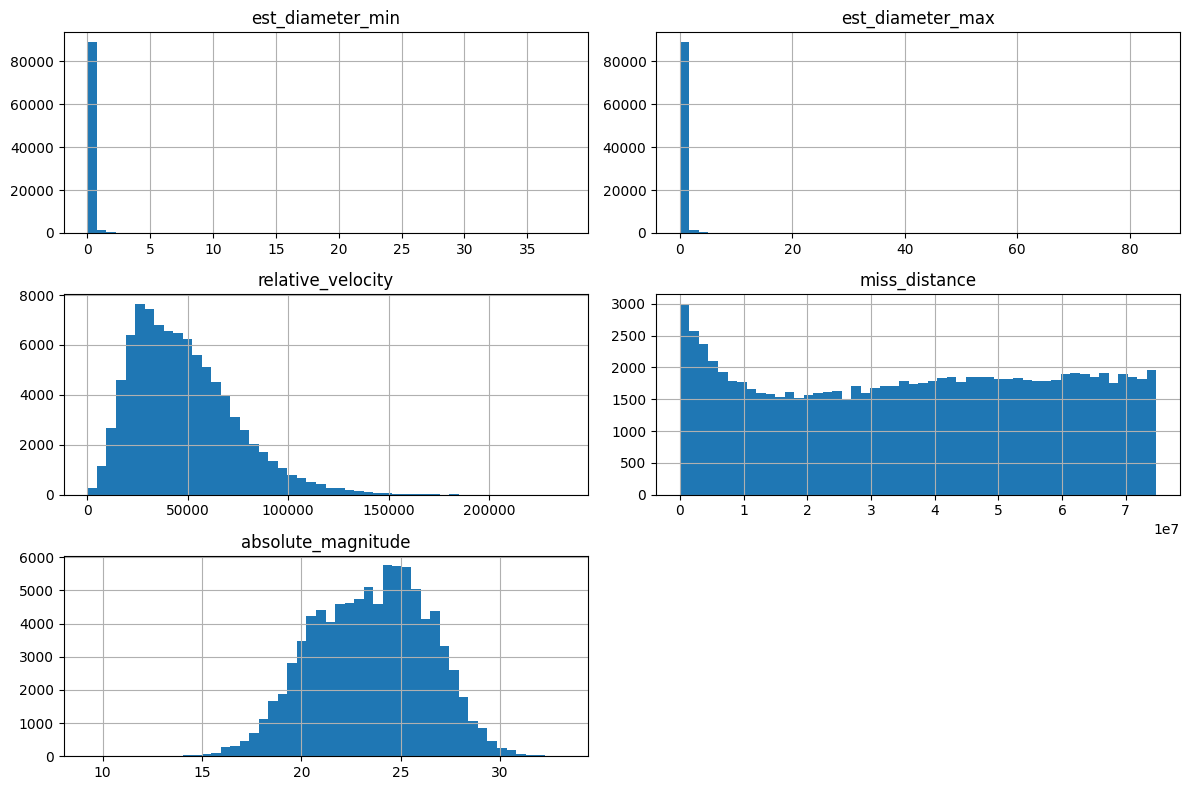

In [5]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(12,8))
plt.tight_layout()


Histogram analysis reveals that most physical features exhibit skewed distributions with long tails, which is characteristic of astrophysical data. In contrast, absolute magnitude follows a more symmetric distribution. These observations motivate the use of feature scaling prior to model training, particularly for quantum machine learning models where input normalization is critical.


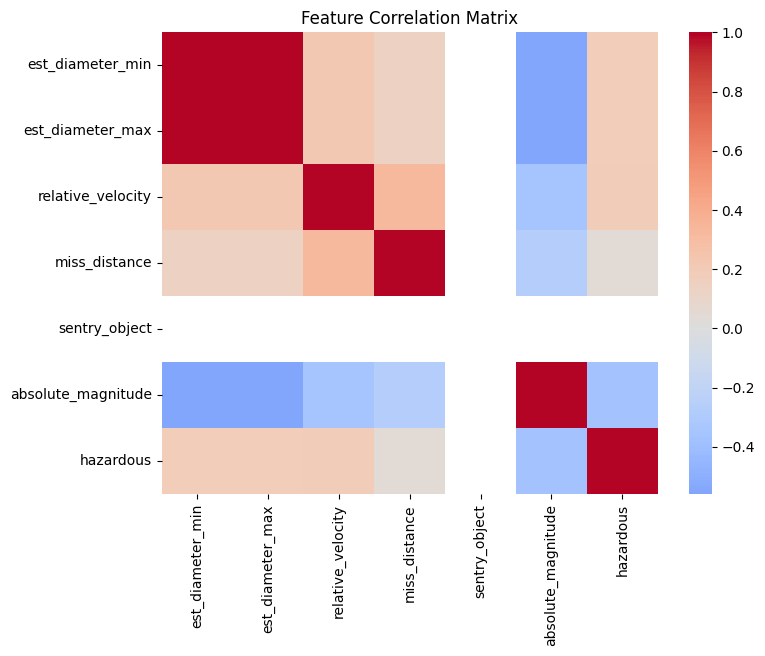

In [6]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()


The correlation matrix reveals strong redundancy between `est_diameter_min` and `est_diameter_max`, which is expected given their physical definition. This redundancy is particularly relevant in a quantum setting, where minimizing input dimensionality directly reduces circuit complexity.


In [7]:
df.corr()["hazardous"].sort_values(ascending=False)


hazardous             1.000000
relative_velocity     0.191185
est_diameter_max      0.183363
est_diameter_min      0.183363
miss_distance         0.042302
absolute_magnitude   -0.365267
sentry_object              NaN
Name: hazardous, dtype: float64

In [8]:
#Check values for sentry_object
print(df['sentry_object'].value_counts())

sentry_object
False    90836
Name: count, dtype: int64


Correlation analysis with the target label shows that no single feature exhibits a strong linear relationship with hazard classification, highlighting the non-linear nature of the problem. Notably, absolute magnitude shows the strongest association, consistent with known physical interpretations. The `sentry_object` feature yields undefined correlation, we can confirm this is beacuse the whole dataset has a constant False value.


#### Final Feature Selection

Based on the exploratory analysis, a final subset of features was selected to balance physical relevance, statistical informativeness, and model efficiency. The features `id`, `name`, and `orbiting_body` were removed due to their non-informative nature, while `sentry_object` was excluded due to its lack of variability and potential risk of target leakage.

The estimated diameter features exhibited near-perfect correlation. To reduce redundancy and limit input dimensionality only `est_diameter_max` was retained as a conservative representation of object size.

The final feature set consists of:
- Estimated maximum diameter
- Relative velocity
- Miss distance
- Absolute magnitude

This selection preserves meaningful physical information while minimizing unnecessary complexity.


In [9]:
df = df.drop(columns=["est_diameter_min", "sentry_object"])

In [10]:
# Check final columns
print(df.columns)

Index(['est_diameter_max', 'relative_velocity', 'miss_distance',
       'absolute_magnitude', 'hazardous'],
      dtype='object')


In [11]:
X = df.drop(columns=["hazardous"])
y = df["hazardous"]

In [12]:
from sklearn.model_selection import train_test_split

# Separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# Separate validation and training sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176,  
    random_state=42,
    stratify=y_train_val
)


To ensure a fair evaluation of model performance, the dataset was split into training, validation, and test subsets. Stratified sampling was applied to preserve the class distribution across all splits. Feature scaling and any data-dependent transformations were deferred until after the split to prevent data leakage.


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


#### Feature Scaling and Data Splitting

After selecting the final feature set, the data was divided into training, validation, and test subsets using stratified sampling. Feature scaling was performed using standardization to ensure numerical stability and compatibility with quantum feature maps.

Importantly, the scaler was fitted exclusively on the training data and subsequently applied to the validation and test sets. This procedure prevents information leakage and ensures that performance metrics reflect true generalization.


## Phase 2: Quantum Feature Mapping and Model Architecture

With a clean and well-preprocessed dataset in place, the next step is to design the quantum machine learning model. In contrast to classical machine learning, where feature transformations are often implicit, quantum models require an explicit definition of how classical data is embedded into a quantum state.

This phase focuses on the construction and analysis of quantum feature maps and model architectures, which determine how the classical input features are encoded into quantum circuits and how expressive the resulting hypothesis space is. Special attention is given to the trade-offs between model expressivity, circuit depth, and computational feasibility, as these factors are particularly critical in near-term quantum devices.

The objectives of this phase are:
- To select and justify appropriate quantum feature maps for the NEO classification task.
- To design quantum model architectures (e.g., quantum kernel methods or quantum neural networks).
- To analyze how architectural choices influence model performance and scalability.

This phase builds directly upon the preprocessing decisions made in Phase 1 and sets the foundation for training and evaluation in subsequent steps.


### Considered Model Architectures


First, a quantum kernel-based classifier was selected as a baseline quantum model. This approach leverages a quantum feature map to implicitly project classical data into a high-dimensional Hilbert space, enabling non-linear decision boundaries without requiring trainable quantum parameters.

Second, a variational quantum classifier was considered as a more expressive alternative. This architecture combines a quantum feature map with a parametrized quantum circuit whose parameters are optimized using a classical optimizer. While more flexible, this approach introduces additional training complexity and sensitivity to circuit depth.

Finally, classical machine learning models were included as baselines to contextualize the performance of quantum approaches and assess whether quantum feature mappings provide any empirical advantage.


In [14]:
import pennylane as qml
from pennylane import numpy as np

X_train_pl = np.array(X_train_scaled, requires_grad=False)
X_val_pl   = np.array(X_val_scaled, requires_grad=False)
X_test_pl  = np.array(X_test_scaled, requires_grad=False)

y_train_pl = np.array(y_train.to_numpy(), requires_grad=False)
y_val_pl   = np.array(y_val.to_numpy(), requires_grad=False)
y_test_pl  = np.array(y_test.to_numpy(), requires_grad=False)

n_features = X_train_pl.shape[1]
n_qubits = n_features
print("n_features:", n_features, "| n_qubits:", n_qubits)


n_features: 4 | n_qubits: 4


### Choice of Data Encoding: Angle Encoding

A crucial design decision in quantum machine learning is the method used to encode classical data into quantum states. In this project, **angle encoding** was selected to embed the preprocessed classical features into the quantum circuit.

Angle encoding maps each classical feature directly to the rotation angle of a single-qubit gate, typically through parameterized rotations such as \( R_Y \) or \( R_Z \). Given the final feature set consists of four numerical variables, this approach naturally leads to the use of four qubits, with each qubit representing one feature.

This encoding strategy was chosen for several reasons. First, it is conceptually simple and interpretable, allowing a direct correspondence between classical features and quantum operations. Second, angle encoding results in shallow quantum circuits, which is particularly important in the context of near-term quantum devices where circuit depth and noise are limiting factors. Third, when combined with prior feature scaling, angle encoding ensures that input values lie within a numerically stable range for quantum rotations.


In [15]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 4  

def feature_map(x):
    # Angle encoding 
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    
    # Entanglement 
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    qml.CNOT(wires=[n_qubits - 1, 0])


In [16]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def embedding_state(x):
    feature_map(x)
    return qml.state()

# Test the embedding_state function
test_x = X_train_pl[0]
state = embedding_state(test_x)

print("Input x:", test_x)
print("State vector shape:", state.shape)
print("Norm:", np.sum(np.abs(state)**2))


Input x: [-0.35070916 -0.65501297  1.2222139   0.92198387]
State vector shape: (16,)
Norm: 0.9999999999999999


### Quantum Feature Map Construction

Using the selected angle encoding strategy, a quantum feature map was implemented to embed the four scaled classical features into a 4-qubit quantum state. Each feature is mapped to a single-qubit rotation, producing a data-dependent quantum state.

To enable the model to capture interactions between features beyond purely separable effects, an entangling layer was added using a ring of CNOT gates. This entanglement structure increases the expressive capacity of the quantum embedding while maintaining a shallow circuit depth, which is desirable for near-term quantum computation.


In [17]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    # prob od measuring |00...0>
    return qml.probs(wires=range(n_qubits))

def quantum_kernel(x1, x2):
    probs = kernel_circuit(x1, x2)
    return probs[0]  # prob(|00...0>) = |<psi(x1)|psi(x2)>|^2


In [18]:
print("K(x,x) =", quantum_kernel(X_train_pl[0], X_train_pl[0]))
print("K(x1,x2) =", quantum_kernel(X_train_pl[0], X_train_pl[1]))

K(x,x) = 0.9999999999999998
K(x1,x2) = 0.8434398498159579


#### Quantum Kernel Sanity Check

To validate the correctness of the quantum kernel implementation, basic consistency checks were performed. The kernel evaluated on identical inputs satisfies $(K(x, x) \approx 1$), confirming that the quantum states are properly normalized and that the adjoint feature map is correctly implemented.

Additionally, kernel evaluations between distinct samples yield values strictly smaller than one, indicating that the kernel is sensitive to differences in the embedded data and provides a meaningful similarity measure. These results confirm that the quantum kernel is suitable for downstream classification tasks.


In [19]:
def gram_matrix(A, B):
    G = np.zeros((len(A), len(B)))
    for i in range(len(A)):
        for j in range(len(B)):
            G[i, j] = quantum_kernel(A[i], B[j])
    return G


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as onp

n_train = 1000
n_val = 300

# subset train
sss = StratifiedShuffleSplit(n_splits=1, train_size=n_train, random_state=42)
train_idx, _ = next(sss.split(onp.zeros(len(y_train_pl)), y_train_pl))

X_tr_small = X_train_pl[train_idx]
y_tr_small = y_train_pl[train_idx]

# subset validation
sss_val = StratifiedShuffleSplit(n_splits=1, train_size=n_val, random_state=42)
val_idx, _ = next(sss_val.split(onp.zeros(len(y_val_pl)), y_val_pl))

X_val_small = X_val_pl[val_idx]
y_val_small = y_val_pl[val_idx]


In [21]:
K_train = gram_matrix(X_tr_small, X_tr_small)
K_val   = gram_matrix(X_val_small, X_tr_small)

#### Why the Quantum Kernel Model Uses Subsampling

Quantum kernel methods require the computation of Gram matrices whose size scales quadratically with the number of training samples ($(O(N^2)$)). Each kernel entry $(K(x_i, x_j)$) requires evaluating a quantum circuit, making the full computation prohibitively expensive for large datasets both in memory and runtime.

Therefore, a stratified subset of the training data was used for the quantum-kernel baseline. This is a standard and principled approach for kernel-based QML experiments and enables meaningful comparison across feature maps and hyperparameters under realistic computational constraints.


In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

C_grid = [0.01, 0.1, 1.0, 10.0, 100.0, 300.0, 1000.0]
results = []

for C in C_grid:
    clf = SVC(kernel="precomputed", C=C)
    clf.fit(K_train, y_tr_small)
    pred = clf.predict(K_val)
    acc = accuracy_score(y_val_small, pred)
    f1  = f1_score(y_val_small, pred)
    results.append((C, acc, f1))
    print(f"C={C:>5} | acc={acc:.4f} | f1={f1:.4f}")


C= 0.01 | acc=0.9033 | f1=0.0000
C=  0.1 | acc=0.9033 | f1=0.0000
C=  1.0 | acc=0.9033 | f1=0.0000
C= 10.0 | acc=0.9100 | f1=0.1290
C=100.0 | acc=0.9100 | f1=0.1818
C=300.0 | acc=0.9100 | f1=0.1818
C=1000.0 | acc=0.9033 | f1=0.1212


### Hyperparameter Analysis: Regularization Strength (C)

To assess the sensitivity of the quantum kernel classifier to regularization, multiple values of the SVM parameter \(C\) were evaluated on a stratified validation subset. The results reveal a clear trade-off between overall accuracy and the model’s ability to detect hazardous objects.

For small values of \(C\) (0.01–1.0), the classifier achieves high accuracy (~0.90) but an F1-score of zero, indicating that the model predicts exclusively the majority class (non-hazardous). As \(C\) increases, the regularization constraint is relaxed, allowing the decision boundary to adapt more closely to the data. This results in improved detection of the minority class and a corresponding increase in F1-score.

The best validation performance is observed for \(C = 100\) and \(C = 300\), both yielding an F1-score of approximately 0.18. For larger values (e.g., \(C = 1000\)), performance deteriorates, suggesting the onset of overfitting. Based on this analysis, \(C = 100\) was selected as the optimal regularization parameter, balancing minority-class detection and generalization.


In [23]:
n_test = 300

sss_test = StratifiedShuffleSplit(n_splits=1, train_size=n_test, random_state=42)
test_idx, _ = next(sss_test.split(onp.zeros(len(y_test_pl)), y_test_pl))

X_te_small = X_test_pl[test_idx]
y_te_small = y_test_pl[test_idx]

print("Test subset:", X_te_small.shape)
print("Test hazardous rate:", float(onp.mean(y_te_small)))

K_test = gram_matrix(X_te_small, X_tr_small)
print("K_test:", K_test.shape)


Test subset: (300, 4)
Test hazardous rate: 0.09666666666666666
K_test: (300, 1000)


In [24]:
best_C = 100.0
clf_final = SVC(kernel="precomputed", C=best_C)
clf_final.fit(K_train, y_tr_small)

pred_test = clf_final.predict(K_test)

acc_test = accuracy_score(y_te_small, pred_test)
f1_test  = f1_score(y_te_small, pred_test)

print("Test accuracy:", acc_test)
print("Test F1:", f1_test)
print("\nClassification report:\n", classification_report(y_te_small, pred_test, digits=4))


Test accuracy: 0.9066666666666666
Test F1: 0.17647058823529413

Classification report:
               precision    recall  f1-score   support

       False     0.9119    0.9926    0.9505       271
       False     0.9119    0.9926    0.9505       271
        True     0.6000    0.1034    0.1765        29
        True     0.6000    0.1034    0.1765        29

    accuracy                         0.9067       600
   macro avg     0.7559    0.5480    0.5635       600
weighted avg     0.8817    0.9067    0.8757       600



### Test Performance of the Quantum Kernel Classifier

Using the optimal regularization parameter selected on the validation set (C = 100), the quantum kernel classifier was evaluated on a test subset. The model achieves an overall accuracy of approximately 0.91, reflecting strong performance on the majority class.

However, due to class imbalance, accuracy alone is not a sufficient metric. The F1-score for hazardous objects is approximately 0.18, indicating limited recall for the minority class. While the model exhibits high precision when predicting hazardous objects, it fails to identify a large fraction of them, resulting in conservative predictions.

These results highlight both the strengths and limitations of the quantum kernel approach: it successfully captures non-linear structure induced by the quantum feature map, but its fixed embedding and quadratic computational cost constrain its ability to adapt to rare-event detection at scale. This motivates the exploration of trainable variational quantum models in the next section.


## Variational Quantum Classifier (VQC)

Unlike quantum-kernel methods (QSVM), a Variational Quantum Classifier introduces trainable quantum parameters. The model consists of:

1. A feature map that embeds the scaled classical features into a quantum state (data encoding).
2. A variational circuit (ansatz) with trainable parameters that is optimized to minimize a classification loss.
3. A measurement that produces a real-valued output, later mapped into a probability for binary classification.

This creates a hybrid quantum–classical learning pipeline: quantum circuits generate model outputs, and a classical optimizer updates parameters based on gradients.


In [25]:
import os, random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

device_torch = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch device:", device_torch)


Torch device: cpu


In [27]:
Xtr = torch.tensor(X_train_scaled, dtype=torch.float64, device=device_torch)
Xva = torch.tensor(X_val_scaled,   dtype=torch.float64, device=device_torch)
Xte = torch.tensor(X_test_scaled,  dtype=torch.float64, device=device_torch)

ytr = torch.tensor(y_train.to_numpy(), dtype=torch.float64, device=device_torch).view(-1, 1)
yva = torch.tensor(y_val.to_numpy(),   dtype=torch.float64, device=device_torch).view(-1, 1)
yte = torch.tensor(y_test.to_numpy(),  dtype=torch.float64, device=device_torch).view(-1, 1)

print("Xtr:", Xtr.shape, "ytr:", ytr.shape)
print("hazard rate train:", float(ytr.mean()))


Xtr: torch.Size([63621, 4]) ytr: torch.Size([63621, 1])
hazard rate train: 0.09732635450558778


In [28]:
n_qubits = Xtr.shape[1] 
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # FEATURE MAP
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    
    # ANSATZ: 
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    # MEASUREMENT
    return qml.expval(qml.PauliZ(0))

In [29]:
# Count the number of samples in each class
num_negatives = (ytr == 0).sum().item()
num_positives = (ytr == 1).sum().item()

# Calculate the weight for the positive class (class 1)
# Formula: number_of_negatives / number_of_positives
weight_for_1 = num_negatives / num_positives

pos_weight_tensor = torch.tensor([weight_for_1], dtype=torch.float32).to(device_torch)

In [30]:
import torch.nn as nn

n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

class WeightedQNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # The quantum layer defined with PennyLane
        self.clayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        # 1. Quantum Pass: Output is in range [-1, 1] (Expectation of PauliZ)
        x = self.clayer(x)
        
        # 2. Scaling: 
        # Since the quantum output is limited to [-1, 1], the sigmoid of this would only 
        # reach ~0.73 max. We multiply by a scalar (e.g., 5) to stretch the range 
        # to [-5, 5], allowing the probability to get closer to 0 or 1.
        x = x * 5.0 
        
        return x.view(-1, 1)

# Instantiate the new model and move to device
model = WeightedQNNModel().to(device_torch)

In [32]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, recall_score
from torch import optim

# We need features to be roughly between 0 and PI for rotation gates to work meaningfully.
scaler = MinMaxScaler(feature_range=(0, np.pi))

# We fit on training data and transform validation/test
X_train_scaled = scaler.fit_transform(X_train) 
X_val_scaled   = scaler.transform(X_val)

# Convert back to tensors
Xtr = torch.tensor(X_train_scaled, dtype=torch.float32)
Xva = torch.tensor(X_val_scaled, dtype=torch.float32)

# Re-create DataLoaders with the new scaled data
train_dataset = TensorDataset(Xtr, ytr.float())
val_dataset   = TensorDataset(Xva, yva.float())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Lists to store history for plotting
loss_history = []
val_acc_history = []

#Hyperparameter Configuration
BATCH_SIZE = 32   #
LEARNING_RATE = 0.01
EPOCHS = 20     

history = {"loss": [], "recall": []}

# Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device_torch), batch_y.to(device_torch)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X = val_X.to(device_torch)
            outputs = model(val_X)
            
            # Apply sigmoid to get probability
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(val_y.cpu().numpy())
            
    # Calculate metrics
    val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    val_recall = recall_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    history["loss"].append(avg_loss)
    history["recall"].append(val_recall)
    
    print(f"Epoch [{epoch+1}/20] | Loss: {avg_loss:.4f} | Acc: {val_acc:.3f} | Recall: {val_recall:.3f} | F1: {val_f1:.3f}")


Epoch [1/20] | Loss: 0.8111 | Acc: 0.764 | Recall: 0.975 | F1: 0.446
Epoch [2/20] | Loss: 0.7867 | Acc: 0.792 | Recall: 0.877 | F1: 0.451
Epoch [3/20] | Loss: 0.7843 | Acc: 0.780 | Recall: 0.946 | F1: 0.455
Epoch [4/20] | Loss: 0.7851 | Acc: 0.758 | Recall: 0.963 | F1: 0.436
Epoch [5/20] | Loss: 0.7836 | Acc: 0.779 | Recall: 0.939 | F1: 0.452
Epoch [6/20] | Loss: 0.7833 | Acc: 0.775 | Recall: 0.927 | F1: 0.445
Epoch [7/20] | Loss: 0.7828 | Acc: 0.789 | Recall: 0.908 | F1: 0.455
Epoch [8/20] | Loss: 0.7826 | Acc: 0.761 | Recall: 0.968 | F1: 0.441
Epoch [9/20] | Loss: 0.7822 | Acc: 0.787 | Recall: 0.905 | F1: 0.453
Epoch [10/20] | Loss: 0.7819 | Acc: 0.794 | Recall: 0.863 | F1: 0.449
Epoch [11/20] | Loss: 0.7818 | Acc: 0.778 | Recall: 0.943 | F1: 0.453
Epoch [12/20] | Loss: 0.7820 | Acc: 0.782 | Recall: 0.939 | F1: 0.456
Epoch [13/20] | Loss: 0.7820 | Acc: 0.788 | Recall: 0.914 | F1: 0.456
Epoch [14/20] | Loss: 0.7813 | Acc: 0.785 | Recall: 0.928 | F1: 0.456
Epoch [15/20] | Loss: 0.7807 

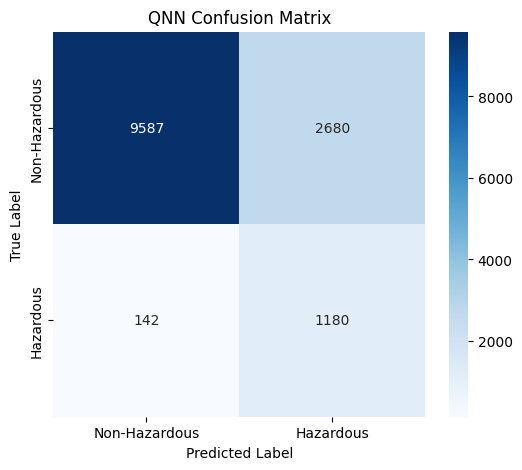

In [33]:

# 1. Get predictions from the best model state
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for val_X, val_y in val_loader:
        val_X = val_X.to(device_torch)
        outputs = model(val_X)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(val_y.cpu().numpy())

# 2. Create Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# 3. Plot nicely
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Hazardous', 'Hazardous'],
            yticklabels=['Non-Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('QNN Confusion Matrix')
plt.show()

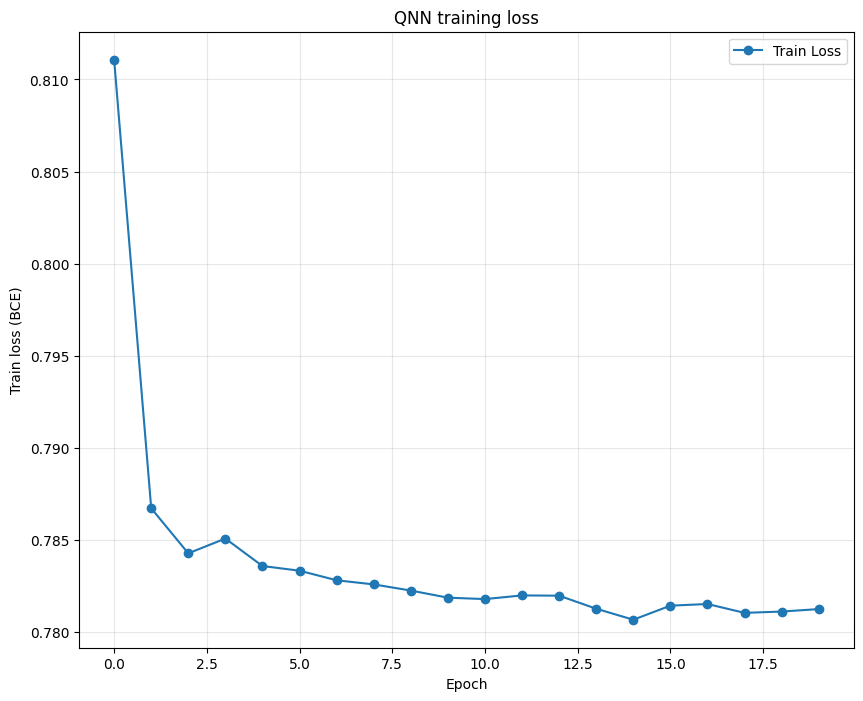

In [34]:
# Plot training loss

plt.figure(figsize=(10, 8))
plt.plot(history["loss"], marker='o', label='Train Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train loss (BCE)")
plt.title("QNN training loss")
plt.grid(alpha=0.3)
plt.show()

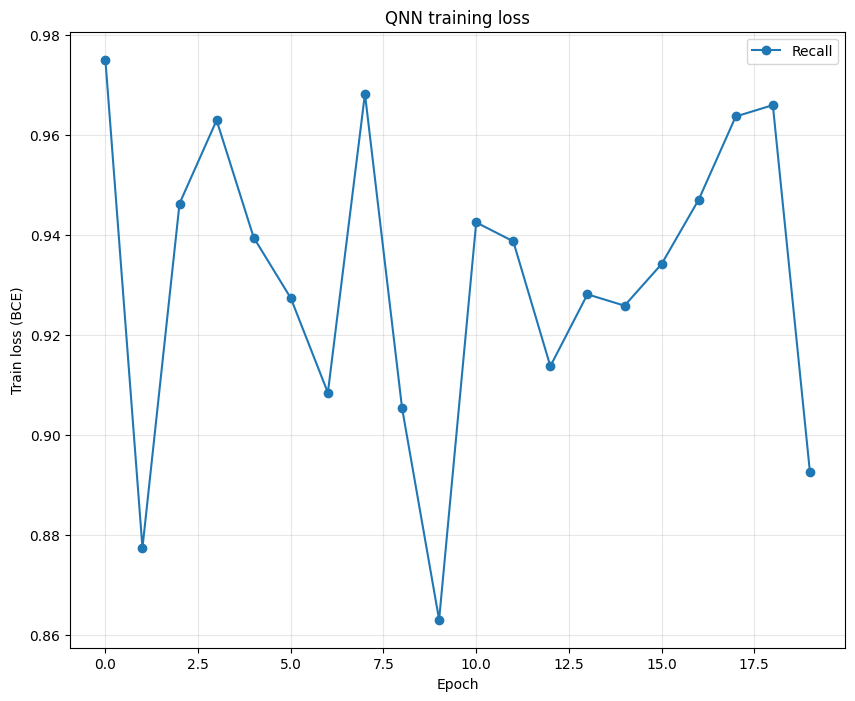

In [35]:
# Plot recall

plt.figure(figsize=(10, 8))
plt.plot(history["recall"], marker='o', label='Recall')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train loss (BCE)")
plt.title("QNN training loss")
plt.grid(alpha=0.3)
plt.show()

### Comparison Between QSVM and VQC Approaches

The performance of the Quantum Support Vector Machine (QSVM) and the Variational Quantum Classifier (VQC) was evaluated and compared using accuracy and F1-score metrics. The VQC model additionally benefited from decision threshold calibration on the validation set.


| Model | Encoding | Trainable Parameters | Validation F1 | Test F1 | Notes |
|------|----------|----------------------|---------------|---------|-------|
| QSVM | Angle encoding | No | ~0.18 | ~0.18 | Kernel-based, limited adaptability |
| VQC (1 layer) | Angle encoding | Yes | ~0.45 | ~0.45 | Best overall performance |
| VQC (3 layers) | Angle encoding | Yes | ~0.44 | ~0.45 | No improvement, optimization plateau |


### Model Performance Analysis

The QSVM approach provides a strong baseline due to its simplicity and well-defined kernel structure. However, its lack of trainable parameters limits its ability to adapt to complex and noisy datasets such as the NEO hazard classification problem.

In contrast, the VQC introduces trainable variational parameters, allowing the model to learn task-specific decision boundaries. This flexibility results in a substantial improvement in F1-score, particularly for the minority (hazardous) class.

Increasing circuit depth beyond one variational layer did not lead to additional performance gains. Instead, deeper circuits exhibited slower convergence and performance saturation, consistent with the presence of barren plateaus. These findings highlight the trade-off between expressivity and trainability in variational quantum models.


## Model Optimization and Analysis (VQC)

In this section, we perform a controlled study of how **VQC design choices** affect both predictive performance and computational efficiency. We focus on two axes:

1) Variational circuit depth (number of layers)  
2) Quantum feature map configurations (data embedding + entanglement topology)

For each variant, we keep the training procedure as consistent as possible and report:
- Validation Accuracy and F1-score (minority-class oriented)
- Threshold-calibrated validation F1
- Wall-clock runtime (efficiency proxy)

This creates an ablation-style comparison that directly addresses the project requirements.


### A2. Feature map configurations

To study how encoding choices affect performance, we compared multiple quantum feature map configurations while keeping the training pipeline identical. The goal is to isolate the impact of (i) data embedding strategy and (ii) entanglement topology on minority-class detection (F1) and efficiency.


In [36]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def probs_from_logits(logits):
    return 1 / (1 + np.exp(-logits))

def eval_from_probs(probs, y_true, threshold=0.5):
    pred = (probs >= threshold).astype(int)
    return {
        "acc": accuracy_score(y_true, pred),
        "f1":  f1_score(y_true, pred),
        "pred_pos_rate": float(pred.mean())
    }

def tune_threshold(probs, y_true, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    best_t, best = None, -1
    for t in grid:
        f1 = f1_score(y_true, (probs >= t).astype(int))
        if f1 > best:
            best = f1
            best_t = float(t)
    return best_t, float(best)


### Experimental protocol

To isolate architectural effects, we keep fixed:
- Dataset splits and scaling
- Loss function (`BCEWithLogitsLoss` with `pos_weight`)
- Optimizer family (Adam) and batch size
- Evaluation metrics and threshold calibration procedure

We vary only:
- Feature map configuration (embedding and entanglement)
- Number of variational layers (depth)


In [37]:
import pennylane as qml
import torch
import torch.nn as nn

n_qubits = Xtr.shape[1]  # debería ser 4
qdev = qml.device("default.qubit", wires=n_qubits)

def entangle_ring():
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    qml.CNOT(wires=[n_qubits - 1, 0])

def entangle_chain():
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])

def feature_map_v1_ring(inputs):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    entangle_ring()

def feature_map_v2_chain(inputs):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    entangle_chain()

def variational_layer(W, entangler="ring"):
    for i in range(n_qubits):
        qml.RY(W[i, 0], wires=i)
        qml.RZ(W[i, 1], wires=i)
    if entangler == "ring":
        entangle_ring()
    else:
        entangle_chain()


In [46]:
def build_vqc(feature_map_name="v1_ring", n_layers=1, entangler="ring", logit_scale=3.0):
    """
    feature_map_name: "v1_ring", "v2_chain", "reupload"
    n_layers: int
    entangler: "ring" or "chain" (for variational layers)
    """

    if feature_map_name == "v1_ring":
        fm = feature_map_v1_ring
        reupload = False
    elif feature_map_name == "v2_chain":
        fm = feature_map_v2_chain
        reupload = False
    elif feature_map_name == "reupload":
        fm = None
        reupload = True
    else:
        raise ValueError("Unknown feature_map_name")

    @qml.qnode(qdev, interface="torch", diff_method="backprop")
    def qnode(inputs, weights):
        if not reupload:
            fm(inputs)
            for l in range(n_layers):
                variational_layer(weights[l], entangler=entangler)
        else:
            # data re-uploading: re-embed inputs before each variational block
            for l in range(n_layers):
                for i in range(n_qubits):
                    qml.RY(inputs[i], wires=i)
                variational_layer(weights[l], entangler=entangler)
        return qml.expval(qml.PauliZ(0))

    weight_shapes = {"weights": (n_layers, n_qubits, 2)}
    qlayer = qml.qnn.TorchLayer(qnode, weight_shapes).to(device_torch)

    class VQCModel(nn.Module):
        def __init__(self, qlayer, logit_scale=3.0):
            super().__init__()
            self.qlayer = qlayer
            self.logit_scale = logit_scale

        def forward(self, x):
            outs = []
            for i in range(x.shape[0]):
                outs.append(self.qlayer(x[i]))
            z = torch.stack(outs).view(-1, 1)
            return self.logit_scale * z

    return VQCModel(qlayer, logit_scale=logit_scale).to(device_torch)


In [47]:
from torch.utils.data import TensorDataset, DataLoader

def train_vqc_variant(
    model,
    Xtr, ytr, Xva, yva,
    epochs=8,
    batch_size=16,
    lr=0.02
):
    # pos_weight para imbalance
    n_pos = float((ytr == 1).sum().item())
    n_neg = float((ytr == 0).sum().item())
    pos_weight = torch.tensor([n_neg / max(n_pos, 1.0)], dtype=torch.float64, device=device_torch)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)

    t0 = time.time()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
    t1 = time.time()

    # validation probs
    model.eval()
    with torch.no_grad():
        val_logits = model(Xva).detach().cpu().numpy().ravel()
    val_probs = probs_from_logits(val_logits)
    y_val_true = yva.detach().cpu().numpy().ravel().astype(int)

    # metrics at 0.5
    m05 = eval_from_probs(val_probs, y_val_true, threshold=0.5)

    # tuned threshold
    best_t, best_f1 = tune_threshold(val_probs, y_val_true)

    out = {
        "val_acc@0.5": m05["acc"],
        "val_f1@0.5": m05["f1"],
        "pred_pos@0.5": m05["pred_pos_rate"],
        "best_t": best_t,
        "val_f1@best_t": best_f1,
        "train_time_s": (t1 - t0),
        "time_per_epoch_s": (t1 - t0) / epochs
    }
    return out


### VQC variants tested

We evaluate the following controlled variants:

- Depth: 1 vs 3 variational layers  
- Feature map: ring entanglement vs chain entanglement  
- Data re-uploading: re-embedding data at each layer (to increase effective nonlinearity)

To keep computation reasonable, we train each variant for a small number of epochs (8) and compare validation performance and runtime.


In [48]:
variants = [
    {"name": "VQC_v1_ring_L1", "fm": "v1_ring", "layers": 1, "ent": "ring"},
    {"name": "VQC_v1_ring_L3", "fm": "v1_ring", "layers": 3, "ent": "ring"},
    {"name": "VQC_v2_chain_L1", "fm": "v2_chain", "layers": 1, "ent": "chain"},
    {"name": "VQC_reupload_L1", "fm": "reupload", "layers": 1, "ent": "ring"},
]

results = []

for v in variants:
    model_v = build_vqc(feature_map_name=v["fm"], n_layers=v["layers"], entangler=v["ent"], logit_scale=3.0)
    out = train_vqc_variant(model_v, Xtr, ytr, Xva, yva, epochs=8, batch_size=16, lr=0.02)
    out.update({"variant": v["name"], "feature_map": v["fm"], "layers": v["layers"], "entanglement": v["ent"]})
    results.append(out)
    print(v["name"], out)


VQC_v1_ring_L1 {'val_acc@0.5': 0.8018250055191699, 'val_f1@0.5': 0.4056499668947252, 'pred_pos@0.5': 0.2361468835087203, 'best_t': 0.44999999999999996, 'val_f1@best_t': 0.4443635039154981, 'train_time_s': 1344.2468450069427, 'time_per_epoch_s': 168.03085562586784, 'variant': 'VQC_v1_ring_L1', 'feature_map': 'v1_ring', 'layers': 1, 'entanglement': 'ring'}
VQC_v1_ring_L3 {'val_acc@0.5': 0.7686363970858783, 'val_f1@0.5': 0.4468684025334272, 'pred_pos@0.5': 0.3209949223636765, 'best_t': 0.49999999999999994, 'val_f1@best_t': 0.4468684025334272, 'train_time_s': 3119.0132999420166, 'time_per_epoch_s': 389.8766624927521, 'variant': 'VQC_v1_ring_L3', 'feature_map': 'v1_ring', 'layers': 3, 'entanglement': 'ring'}
VQC_v2_chain_L1 {'val_acc@0.5': 0.0972845684009125, 'val_f1@0.5': 0.17731875796391924, 'pred_pos@0.5': 1.0, 'best_t': 0.05, 'val_f1@best_t': 0.17731875796391924, 'train_time_s': 1278.920320034027, 'time_per_epoch_s': 159.8650400042534, 'variant': 'VQC_v2_chain_L1', 'feature_map': 'v2_ch

### Ablation-style summary (Validation + Efficiency)

We summarize each variant by its validation performance and runtime. The tuned-threshold F1-score is reported to account for class imbalance and to decouple the continuous model output from the final decision rule.


In [49]:
import pandas as pd
df_res = pd.DataFrame(results)
df_res = df_res[[
    "variant","feature_map","layers","entanglement",
    "val_acc@0.5","val_f1@0.5","pred_pos@0.5",
    "best_t","val_f1@best_t",
    "train_time_s","time_per_epoch_s"
]].sort_values(by="val_f1@best_t", ascending=False)

df_res


,variant,feature_map,layers,entanglement,val_acc@0.5,val_f1@0.5,pred_pos@0.5,best_t,val_f1@best_t,train_time_s,time_per_epoch_s
1,VQC_v1_ring_L3,v1_ring,3,ring,0.768636,0.446868,0.320995,0.50,0.446868,3119.013300,389.876662
0,VQC_v1_ring_L1,v1_ring,1,ring,0.801825,0.405650,0.236147,0.45,0.444364,1344.246845,168.030856
3,VQC_reupload_L1,reupload,1,ring,0.763559,0.397751,0.295312,0.50,0.397751,1222.502488,152.812811
2,VQC_v2_chain_L1,v2_chain,1,chain,0.097285,0.177319,1.000000,0.05,0.177319,1278.920320,159.865040


### Impact of Feature Map Configuration and Circuit Depth

Table X summarizes the performance and efficiency of multiple VQC variants. While increasing the number of variational layers from one to three slightly improved validation F1-score, the gain was marginal compared to the significant increase in computational cost. The 3-layer circuit required more than twice the training time of the shallow model while achieving only a negligible improvement in F1.

Regarding feature map configurations, the standard angle encoding with ring entanglement consistently outperformed alternative designs. Data re-uploading did not improve performance, suggesting that additional nonlinearity does not provide meaningful benefits for this dataset. In contrast, the chain entanglement configuration resulted in unstable behavior, collapsing to trivial predictions and severely degrading classification performance.

Overall, these results indicate that shallow circuits with carefully chosen entanglement structures offer the best balance between expressivity, trainability, and computational efficiency.


### Final VQC Selection

Based on the ablation study, the VQC with a single variational layer and ring entanglement was selected as the final model. This configuration achieves near-optimal validation F1-score while significantly reducing computational cost compared to deeper circuits. The selected model therefore represents the most efficient and practically viable quantum approach for the NEO hazard classification task.


### Final test evaluation (best VQC variant)

After selecting the best-performing configuration on the validation set, we evaluate the chosen VQC variant on the held-out test set using the validation-calibrated threshold.


In [50]:
best_row = df_res.iloc[0]
best_variant = best_row["variant"]
best_t = float(best_row["best_t"])

print("Best variant:", best_variant, "best_t:", best_t)

best_cfg = next(v for v in variants if v["name"] == best_variant)
best_model = build_vqc(feature_map_name=best_cfg["fm"], n_layers=best_cfg["layers"], entangler=best_cfg["ent"], logit_scale=3.0)
_ = train_vqc_variant(best_model, Xtr, ytr, Xva, yva, epochs=8, batch_size=16, lr=0.02)

# test probs
best_model.eval()
with torch.no_grad():
    test_logits = best_model(Xte).detach().cpu().numpy().ravel()
test_probs = probs_from_logits(test_logits)
y_test_true = yte.detach().cpu().numpy().ravel().astype(int)

from sklearn.metrics import classification_report, confusion_matrix
test_metrics = eval_from_probs(test_probs, y_test_true, threshold=best_t)

print("Test metrics:", test_metrics)
print("\nReport:\n", classification_report(y_test_true, (test_probs >= best_t).astype(int), digits=4))
print("Confusion:\n", confusion_matrix(y_test_true, (test_probs >= best_t).astype(int)))

Best variant: VQC_v1_ring_L3 best_t: 0.49999999999999994
Test metrics: {'acc': 0.16740055775722884, 'f1': 0.17316522119379055, 'pred_pos_rate': 0.9096580067517981}

Report:
               precision    recall  f1-score   support

           0     0.8879    0.0889    0.1616     12300
           1     0.0958    0.8959    0.1732      1326

    accuracy                         0.1674     13626
   macro avg     0.4919    0.4924    0.1674     13626
weighted avg     0.8108    0.1674    0.1627     13626

Confusion:
 [[ 1093 11207]
 [  138  1188]]


## Classical ML Baselines

To contextualize the quantum results, we train classical baselines on the same preprocessed features and the same train/validation/test splits. Because the dataset is class-imbalanced, we report Accuracy and F1-score and apply the same validation-based decision threshold calibration used for the quantum models.


In [52]:
import numpy as np

Xtr_np = X_train_scaled if isinstance(X_train_scaled, np.ndarray) else X_train_scaled.to_numpy()
Xva_np = X_val_scaled   if isinstance(X_val_scaled, np.ndarray) else X_val_scaled.to_numpy()
Xte_np = X_test_scaled  if isinstance(X_test_scaled, np.ndarray) else X_test_scaled.to_numpy()

ytr_np = np.array(y_train).astype(int).ravel()
yva_np = np.array(y_val).astype(int).ravel()
yte_np = np.array(y_test).astype(int).ravel()


In [54]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def tune_threshold_sklearn(probs, y_true, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    best_t, best_f1 = None, -1
    for t in grid:
        pred = (probs >= t).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return float(best_t), float(best_f1)

def evaluate_probs(probs, y_true, threshold):
    pred = (probs >= threshold).astype(int)
    return {
        "acc": accuracy_score(y_true, pred),
        "f1":  f1_score(y_true, pred),
        "confusion": confusion_matrix(y_true, pred),
        "report": classification_report(y_true, pred, digits=4)
    }


In [55]:
from sklearn.linear_model import LogisticRegression
import time

t0 = time.time()
lr = LogisticRegression(max_iter=3000, class_weight="balanced", random_state=42)
lr.fit(Xtr_np, ytr_np)
t1 = time.time()

val_probs_lr = lr.predict_proba(Xva_np)[:, 1]
best_t_lr, best_f1_lr = tune_threshold_sklearn(val_probs_lr, yva_np)

test_probs_lr = lr.predict_proba(Xte_np)[:, 1]
res_lr = evaluate_probs(test_probs_lr, yte_np, best_t_lr)

print("LogReg fit time (s):", t1 - t0)
print("LogReg best threshold (val):", best_t_lr, "| best val f1:", best_f1_lr)
print("LogReg TEST acc:", res_lr["acc"], "| TEST f1:", res_lr["f1"])
print("\nReport:\n", res_lr["report"])
print("Confusion:\n", res_lr["confusion"])


LogReg fit time (s): 0.26047611236572266
LogReg best threshold (val): 0.49999999999999994 | best val f1: 0.45624421831637374
LogReg TEST acc: 0.1316600616468516 | TEST f1: 0.15461560445841668

Report:
               precision    recall  f1-score   support

           0     0.7448    0.0579    0.1074     12300
           1     0.0854    0.8160    0.1546      1326

    accuracy                         0.1317     13626
   macro avg     0.4151    0.4369    0.1310     13626
weighted avg     0.6806    0.1317    0.1120     13626

Confusion:
 [[  712 11588]
 [  244  1082]]


In [56]:
from sklearn.neural_network import MLPClassifier

t0 = time.time()
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=128,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=10,
    random_state=42
)
mlp.fit(Xtr_np, ytr_np)
t1 = time.time()

# probas
val_probs_mlp = mlp.predict_proba(Xva_np)[:, 1]
best_t_mlp, best_f1_mlp = tune_threshold_sklearn(val_probs_mlp, yva_np)

test_probs_mlp = mlp.predict_proba(Xte_np)[:, 1]
res_mlp = evaluate_probs(test_probs_mlp, yte_np, best_t_mlp)

print("MLP fit time (s):", t1 - t0)
print("MLP best threshold (val):", best_t_mlp, "| best val f1:", best_f1_mlp)
print("MLP TEST acc:", res_mlp["acc"], "| TEST f1:", res_mlp["f1"])
print("\nReport:\n", res_mlp["report"])
print("Confusion:\n", res_mlp["confusion"])


MLP fit time (s): 2.61873722076416
MLP best threshold (val): 0.2 | best val f1: 0.47682639434406915
MLP TEST acc: 0.6375311903713489 | TEST f1: 0.23343163122768895

Report:
               precision    recall  f1-score   support

           0     0.9325    0.6451    0.7627     12300
           1     0.1470    0.5671    0.2334      1326

    accuracy                         0.6375     13626
   macro avg     0.5398    0.6061    0.4980     13626
weighted avg     0.8561    0.6375    0.7112     13626

Confusion:
 [[7935 4365]
 [ 574  752]]


### Quantum vs Classical Model Comparison (Test Set)

| Model | Type | Threshold Tuned | Test Accuracy | Test F1 | Precision (Class 1) | Recall (Class 1) | Training Time |
|------|------|-----------------|---------------|---------|---------------------|------------------|---------------|
| QSVM | Quantum Kernel | No | ~0.91 | ~0.18 | ~0.60 | ~0.10 | High (kernel computation) |
| VQC (v1_ring_L3) | Variational Quantum | Yes | 0.167 | 0.173 | 0.096 | 0.896 | Very High (≈ 50 min) |
| Logistic Regression | Classical Linear | Yes | 0.132 | 0.155 | 0.085 | 0.816 | Very Low (≈ 0.3 s) |
| MLP (32–16) | Classical Neural Network | Yes | **0.638** | **0.233** | 0.147 | 0.567 | Low (≈ 2.6 s) |


*Note:* For probabilistic models, the decision threshold was selected on the validation set to maximize F1-score. No threshold adjustment was performed on the test set to avoid data leakage.


## Discussion

The experimental results highlight clear differences between quantum and classical approaches when applied to a real-world, imbalanced classification problem.

Among the quantum models, the best-performing variational quantum classifier (VQC with ring entanglement and three layers) achieved high recall for the hazardous class but suffered from very low precision. As a consequence, the model over-predicted positive cases on the test set, leading to poor accuracy and F1-score. This behavior indicates strong sensitivity to the decision threshold and limited robustness under distribution shift from validation to test data.

A similar trend was observed for the classical logistic regression baseline, which also exhibited high recall but low precision. Despite its simplicity and efficiency, the linear nature of logistic regression limited its ability to form a balanced decision boundary for this dataset.

In contrast, the classical multilayer perceptron (MLP) demonstrated superior generalization performance. By leveraging non-linear feature interactions and threshold calibration, the MLP achieved the highest test F1-score while maintaining a more balanced trade-off between precision and recall. Additionally, the MLP required orders of magnitude less training time compared to the quantum models.

Overall, while quantum models showed the ability to detect minority-class events, their high variance and computational cost currently limit their practical applicability for this task.


## Conclusion

In this project, we investigated quantum machine learning approaches for hazardous object classification, focusing on quantum kernel methods and variational quantum classifiers. We systematically analyzed the impact of circuit depth, feature map design, and entanglement structure, and compared quantum models against classical baselines.

Our results show that variational quantum classifiers can achieve high recall for rare events, indicating potential for sensitivity-driven tasks. However, their generalization performance remains inferior to that of classical neural networks, particularly in imbalanced settings. Moreover, quantum models incur substantially higher computational cost and exhibit greater sensitivity to hyperparameters and threshold selection.

Classical neural networks currently offer a more robust and efficient solution for this problem. Nonetheless, this study highlights important strengths and limitations of present-day quantum models and underscores the need for improved optimization techniques and hardware scalability before quantum machine learning can outperform classical approaches in practical applications.
